In [1]:
# =====================================================
# 1. Import Libraries
# =====================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import joblib

from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')   # (for lemmatizer support)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Welcome\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Welcome\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Welcome\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
# =====================================================
# 2. Load Dataset
# =====================================================
df = pd.read_csv("../data/tweets.csv")
print(df.head())
print(df['airline_sentiment'].value_counts())

             tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnar

In [3]:
# Rename columns for clarity
df = df[['text', 'airline_sentiment']].rename(columns={'text':'tweet', 'airline_sentiment':'sentiment'})

In [4]:
# =====================================================
# 3. Text Preprocessing
# =====================================================
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_tweet(tweet):
    tweet = str(tweet).lower()
    tweet = re.sub(r'http\S+', '', tweet)           # remove links
    tweet = re.sub(r'@\w+', '', tweet)              # remove mentions
    tweet = re.sub(r'#', '', tweet)                 # remove hashtag symbol
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    tweet = re.sub(r'\d+', '', tweet)               # remove numbers
    tweet = " ".join([lemmatizer.lemmatize(word) for word in tweet.split() if word not in stop_words])
    return tweet

df['clean_tweet'] = df['tweet'].apply(clean_tweet)
print(df.head())

                                               tweet sentiment  \
0                @VirginAmerica What @dhepburn said.   neutral   
1  @VirginAmerica plus you've added commercials t...  positive   
2  @VirginAmerica I didn't today... Must mean I n...   neutral   
3  @VirginAmerica it's really aggressive to blast...  negative   
4  @VirginAmerica and it's a really big bad thing...  negative   

                                         clean_tweet  
0                                               said  
1       plus youve added commercial experience tacky  
2       didnt today must mean need take another trip  
3  really aggressive blast obnoxious entertainmen...  
4                               really big bad thing  


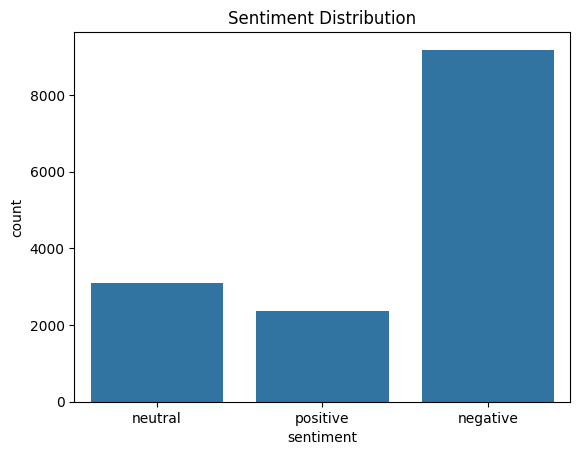

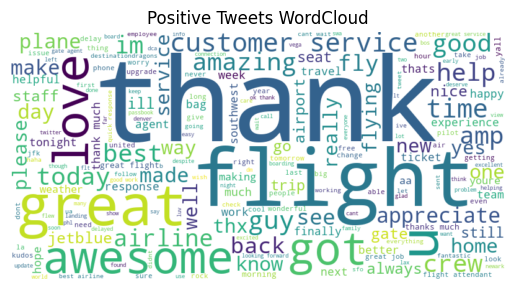

In [5]:
# =====================================================
# 4. Exploratory Data Analysis (EDA)
# =====================================================
sns.countplot(x='sentiment', data=df)
plt.title("Sentiment Distribution")
plt.show()

# Wordcloud for positive tweets
positive_text = " ".join(df[df['sentiment']=="positive"]['clean_tweet'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Positive Tweets WordCloud")
plt.show()

In [6]:
# =====================================================
# 5. Train-Test Split
# =====================================================
X = df['clean_tweet']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:

# =====================================================
# 6. Feature Extraction (TF-IDF)
# =====================================================
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [8]:
# =====================================================
# 7. Model Training (Logistic Regression)
# =====================================================
model = LogisticRegression(max_iter=200)
model.fit(X_train_tfidf, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,200
,multi_class,'deprecated'


              precision    recall  f1-score   support

    negative       0.81      0.94      0.87      1835
     neutral       0.66      0.51      0.58       620
    positive       0.81      0.55      0.65       473

    accuracy                           0.79      2928
   macro avg       0.76      0.67      0.70      2928
weighted avg       0.78      0.79      0.77      2928



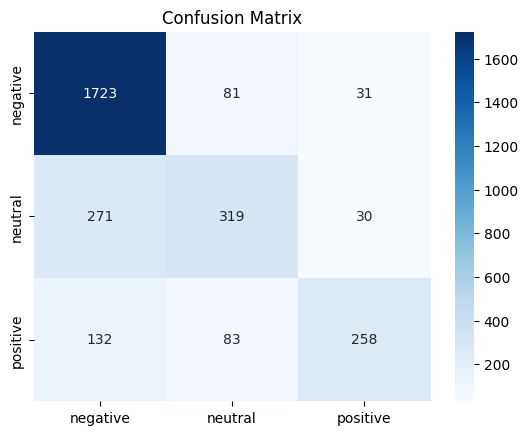

In [9]:
# =====================================================
# 8. Evaluation
# =====================================================
y_pred = model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Confusion Matrix")
plt.show()


In [10]:
# =====================================================
# 9. Save Model + Vectorizer
# =====================================================
joblib.dump(model, "../models/model.pkl")
joblib.dump(vectorizer, "../models/vectorizer.pkl")

print("Model and vectorizer saved!")

Model and vectorizer saved!
